In [6]:
from utils.parsing import parse_snp500
from utils.data import TradingDataset, show_data

from torch.utils.data import DataLoader

# Устанавливаем гиперпараметры

In [7]:
MAX_LENGHT = 256
TEST_LENGHT = 32
SPLIT_COEFF = 0.1
BATCH_SIZE = 16

# Парсим данные snp500 в папку "data/" если их нет

In [16]:
# # парсим данные за последние 7+ лет (выборка бOльшего размера просто не влезет в память)
# parse_snp500(dirpath='data/', 
#              start='2017-01-01', 
#              timeframe='1d', 
#              max_train_len=256, 
#              test_len=32, 
#              split_coeff=0.1)

# Создаём loader'ы для train и val выборок

In [78]:
# Получаем датасеты данных для обучения и валидации
train_dataset = TradingDataset(root_dir="data/train", train_len=256, test_len=32)
val_dataset = TradingDataset(root_dir="data/val", train_len=256, test_len=32)

print(f"Train dataset lenght: {len(train_dataset)}\nValidation dataset lenght: {len(val_dataset)}\n")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train loader lenght: {len(train_loader)}\nValidation loader lenght: {len(val_loader)}")

Train dataset lenght: 575061
Validation dataset lenght: 63673

Train loader lenght: 35942
Validation loader lenght: 3980


# Посмотрим на то что хранится в loader'ах

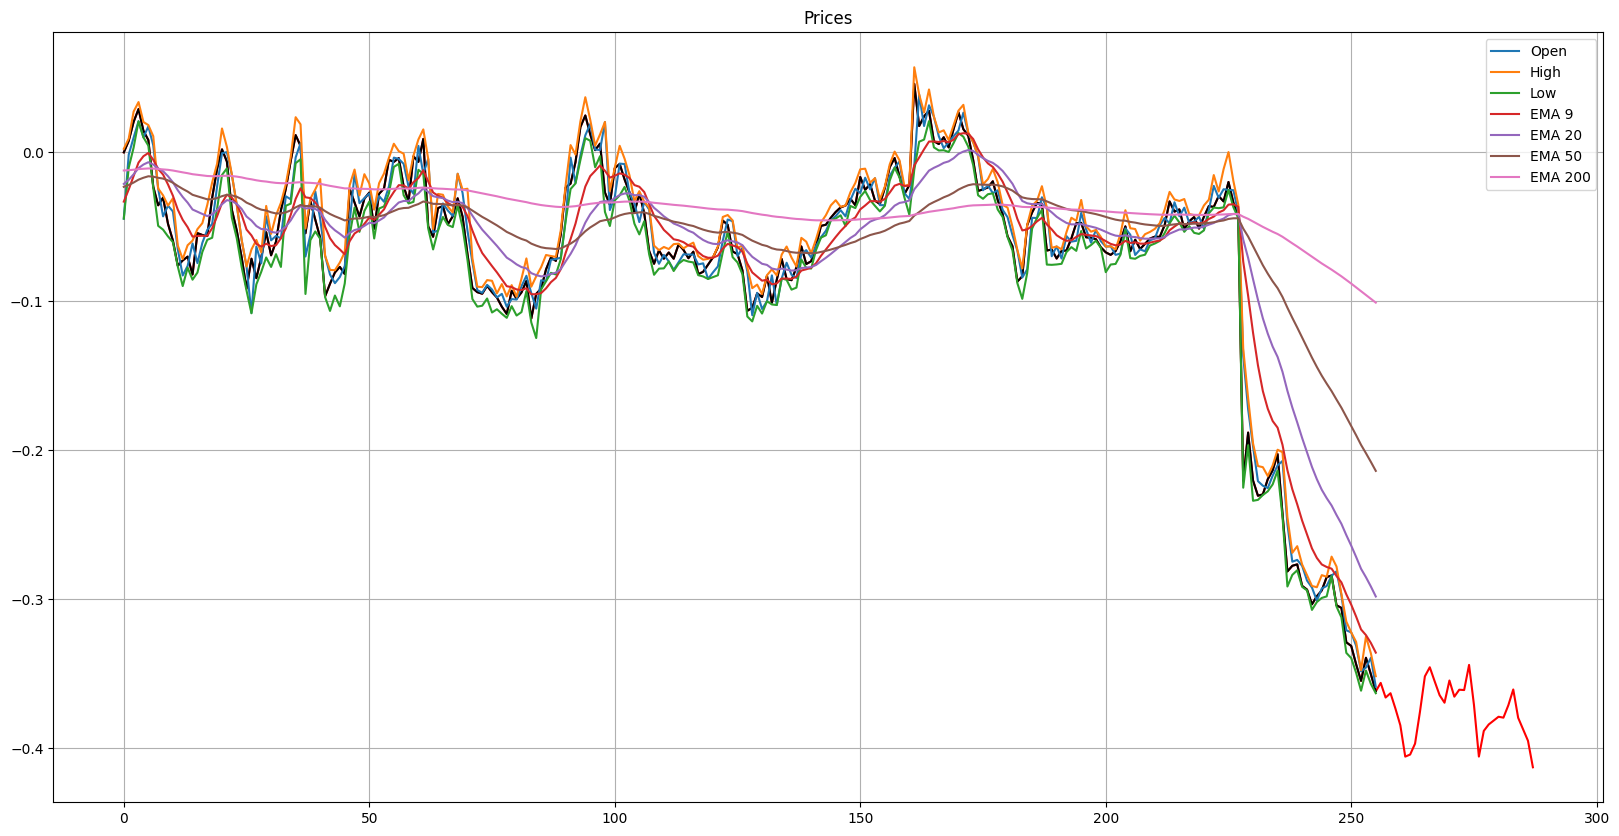

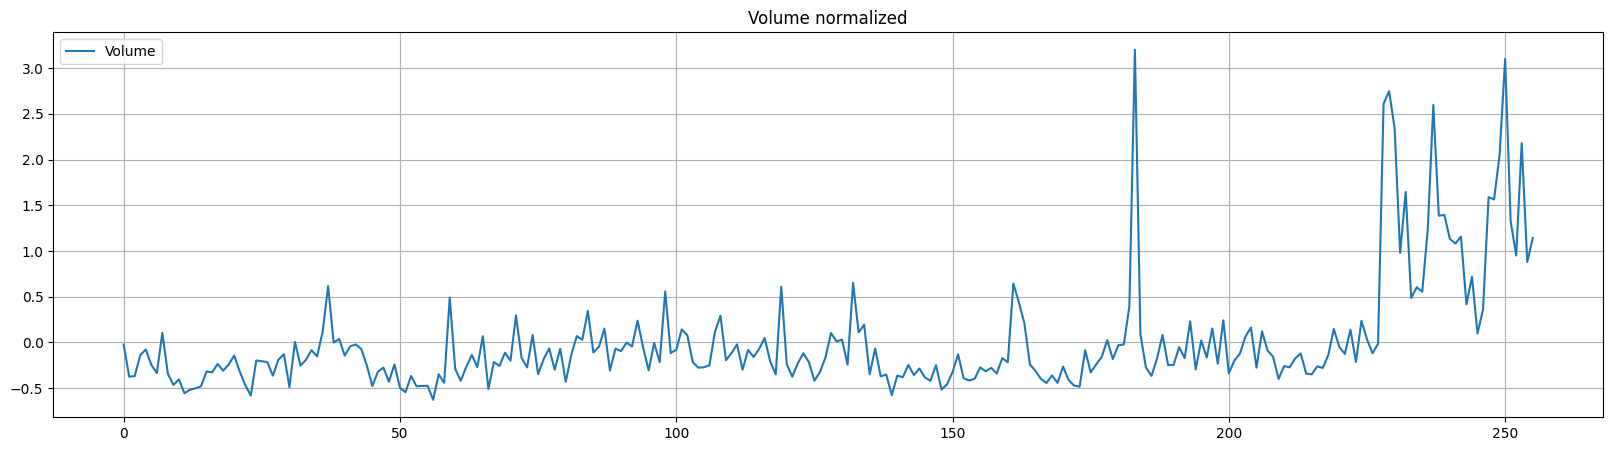

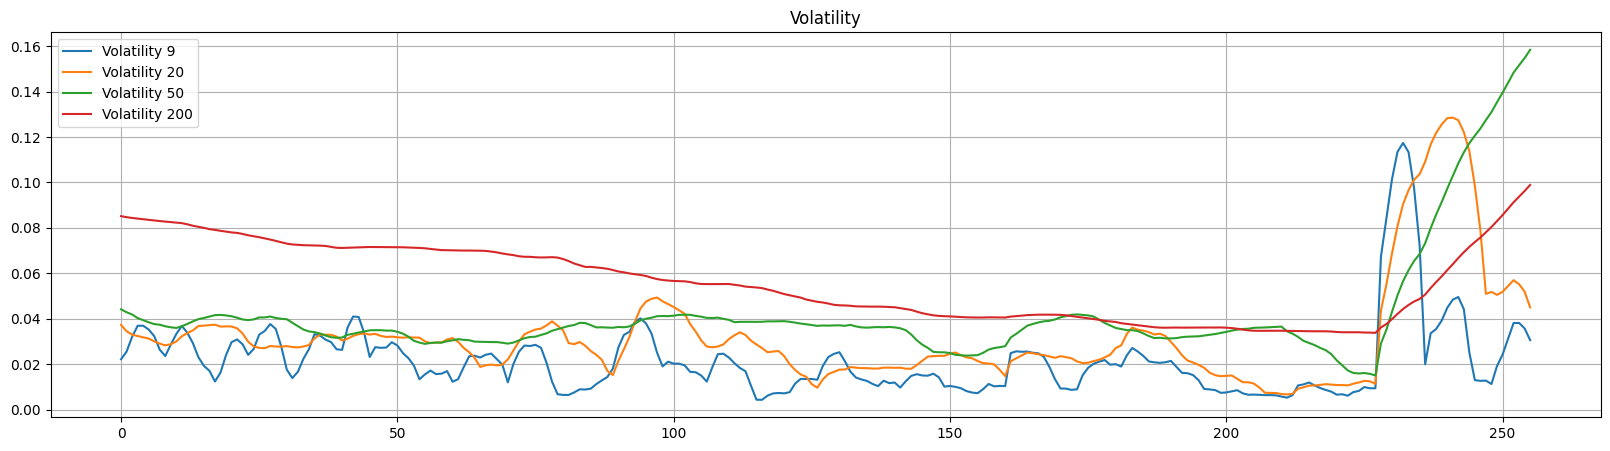

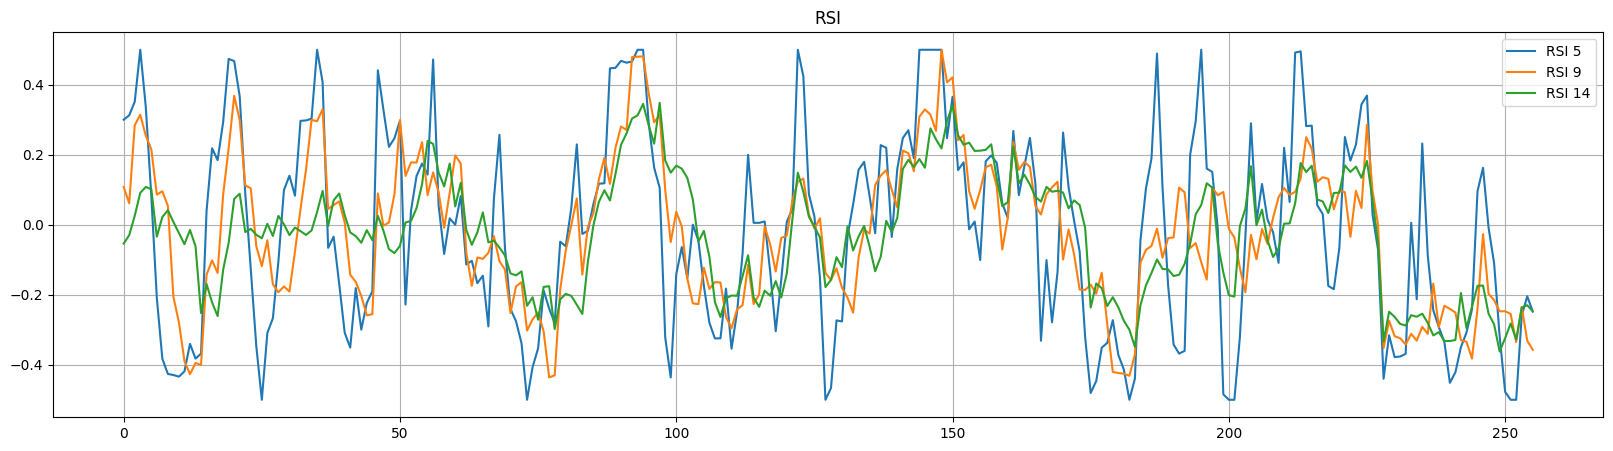

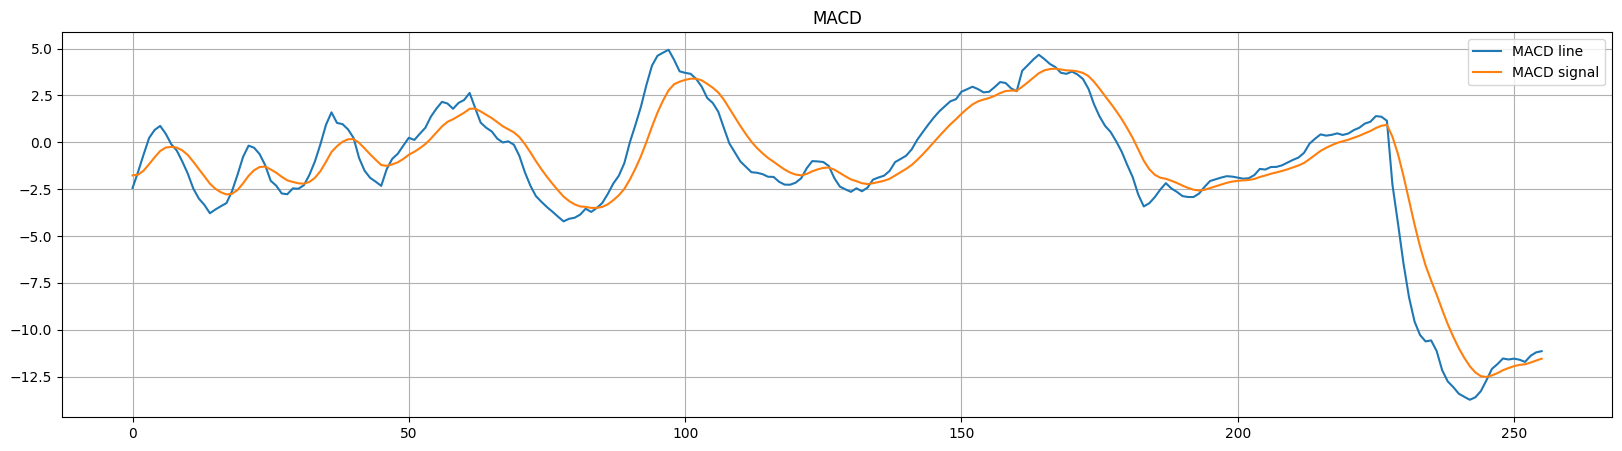

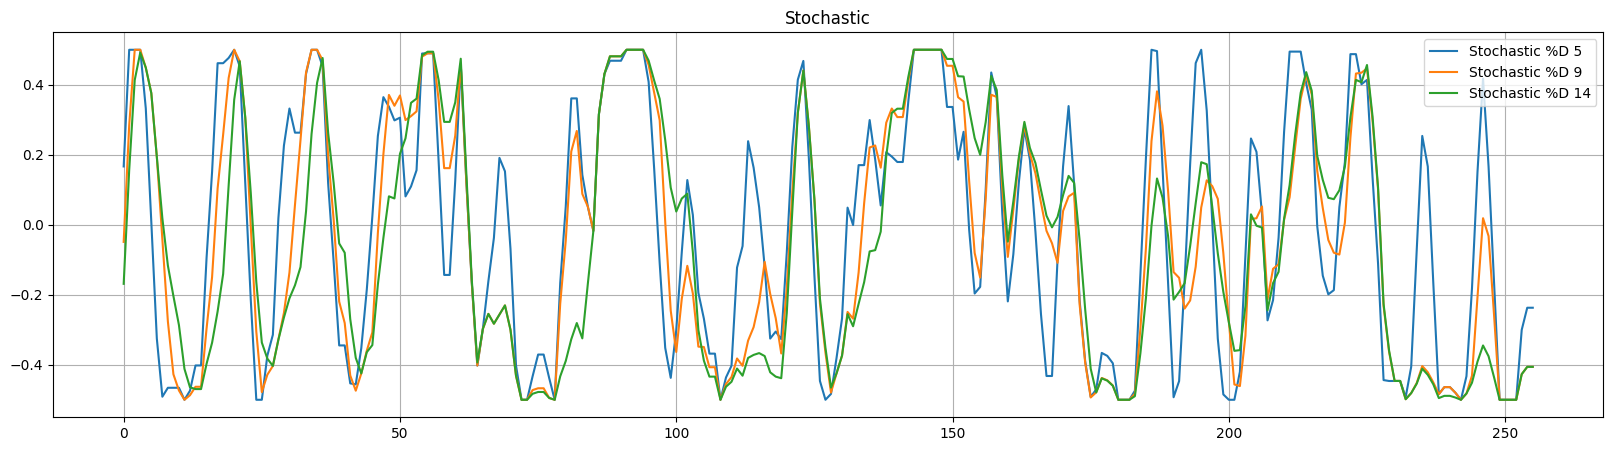

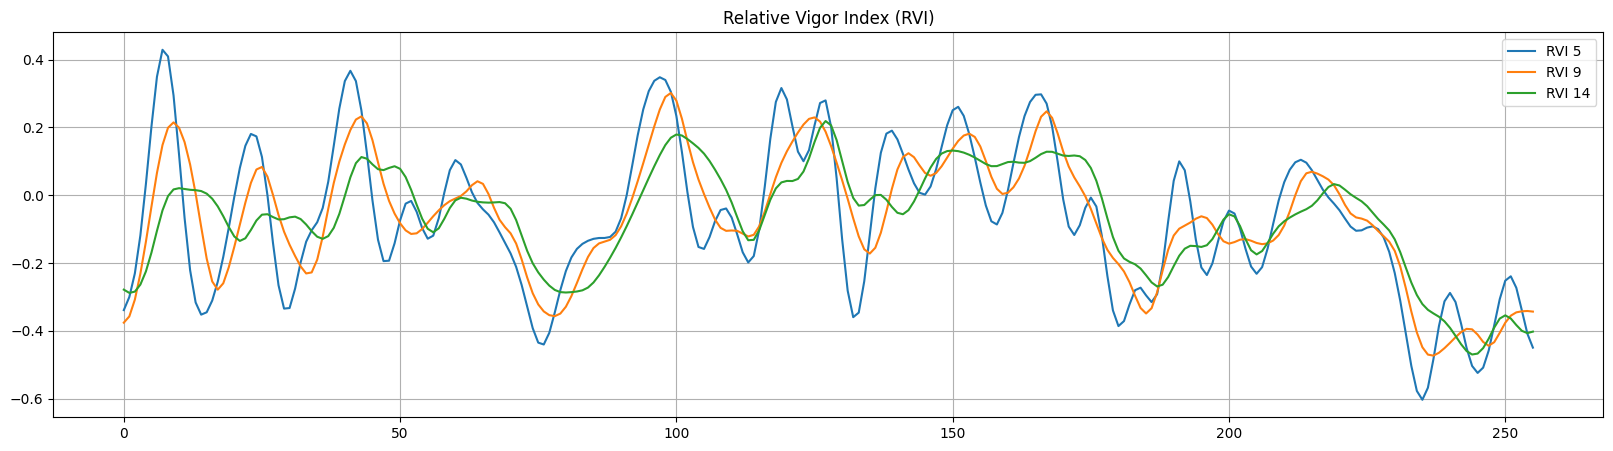

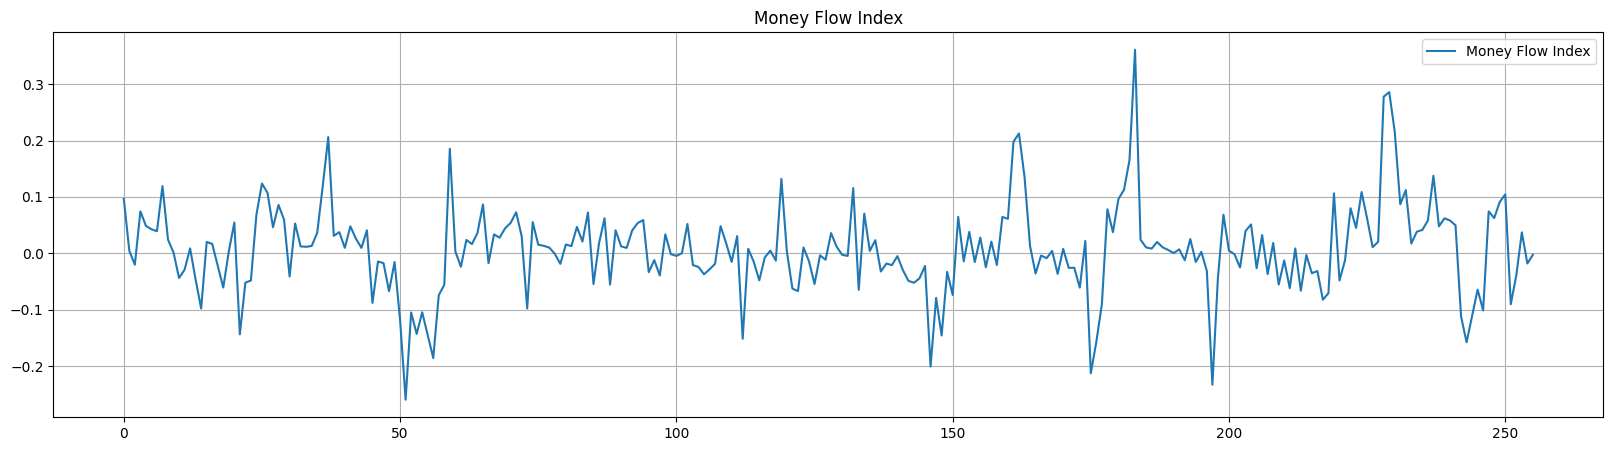

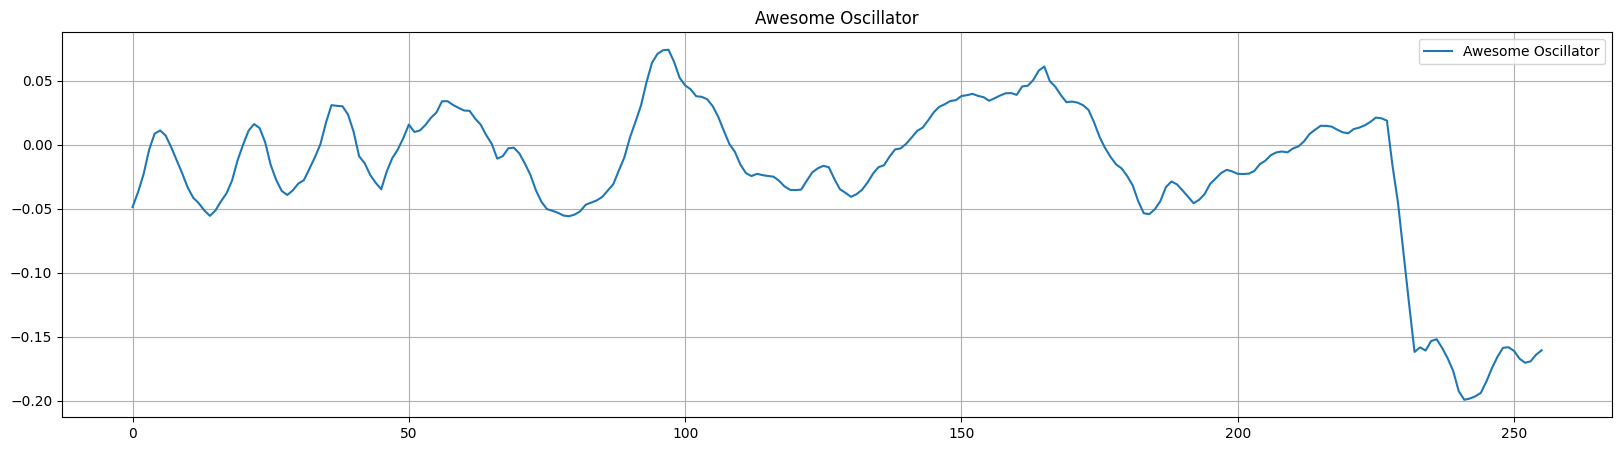

In [79]:
show_data(val_loader)

# Построим модель

In [84]:
%run models/UNetBased.py

myModel = UNetBased(seq_len=256)
myModel

UNetBased(
  (extraction): Extractor(
    (extractor): Sequential(
      (0): ExtractorBlock(
        (extractor_block): Sequential(
          (0): Conv1d(26, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU()
          (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): ExtractorBlock(
        (extractor_block): Sequential(
          (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU()
          (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): ExtractorBlock(
        (extractor_block): Sequential(
          (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU()
          (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
  )
  (encoder): ModuleList(
    (0): UNetEncoderBlock(
      (conv_blocks): Sequential(
        (0): ConvBlock(
 

In [88]:
train_sample = next(iter(train_loader))[0]
myModel(train_sample).shape, next(iter(train_loader))[1].shape

torch.Size([16, 64, 32])
torch.Size([16, 64, 16]) torch.Size([16, 64, 32])
torch.Size([16, 128, 8]) torch.Size([16, 128, 16])
torch.Size([16, 256, 4]) torch.Size([16, 256, 8])
torch.Size([16, 512, 2]) torch.Size([16, 512, 4])
torch.Size([16, 1024, 2])
torch.Size([16, 512, 4])
torch.Size([16, 256, 8])
torch.Size([16, 128, 16])
torch.Size([16, 64, 32])


(torch.Size([16, 1, 32]), torch.Size([16, 1, 32]))

In [86]:
import os
import matplotlib.pyplot as plt

def show_quality (model, loader, num=4):
    train, test = next(iter(loader))
    
    train = train[:num]
    test = test[:num]
    
    pred = model(train).detach()

    fig, axs = plt.subplots(int(num**(1/2)), int(num**(1/2)), figsize=(20, 10))
    
    for i in range(num):
        row = i // int(num**(1/2))
        col = i % int(num**(1/2))

        real = torch.hstack((train[i, 3, :], test[i, 0, :]))
        predict = torch.hstack((train[i, 3, :], pred[i, 0, :]))

        axs[row, col].plot(predict, "red")
        axs[row, col].plot(real, "black")
        axs[row, col].grid()
    
    image_path = 'plot_image.png'
    plt.savefig(image_path)
    plt.show()

    os.remove(image_path)

torch.Size([4, 64, 32])
torch.Size([4, 64, 16]) torch.Size([4, 64, 32])
torch.Size([4, 128, 8]) torch.Size([4, 128, 16])
torch.Size([4, 256, 4]) torch.Size([4, 256, 8])
torch.Size([4, 512, 2]) torch.Size([4, 512, 4])
torch.Size([4, 1024, 2])
torch.Size([4, 512, 4])
torch.Size([4, 256, 8])
torch.Size([4, 128, 16])
torch.Size([4, 64, 32])


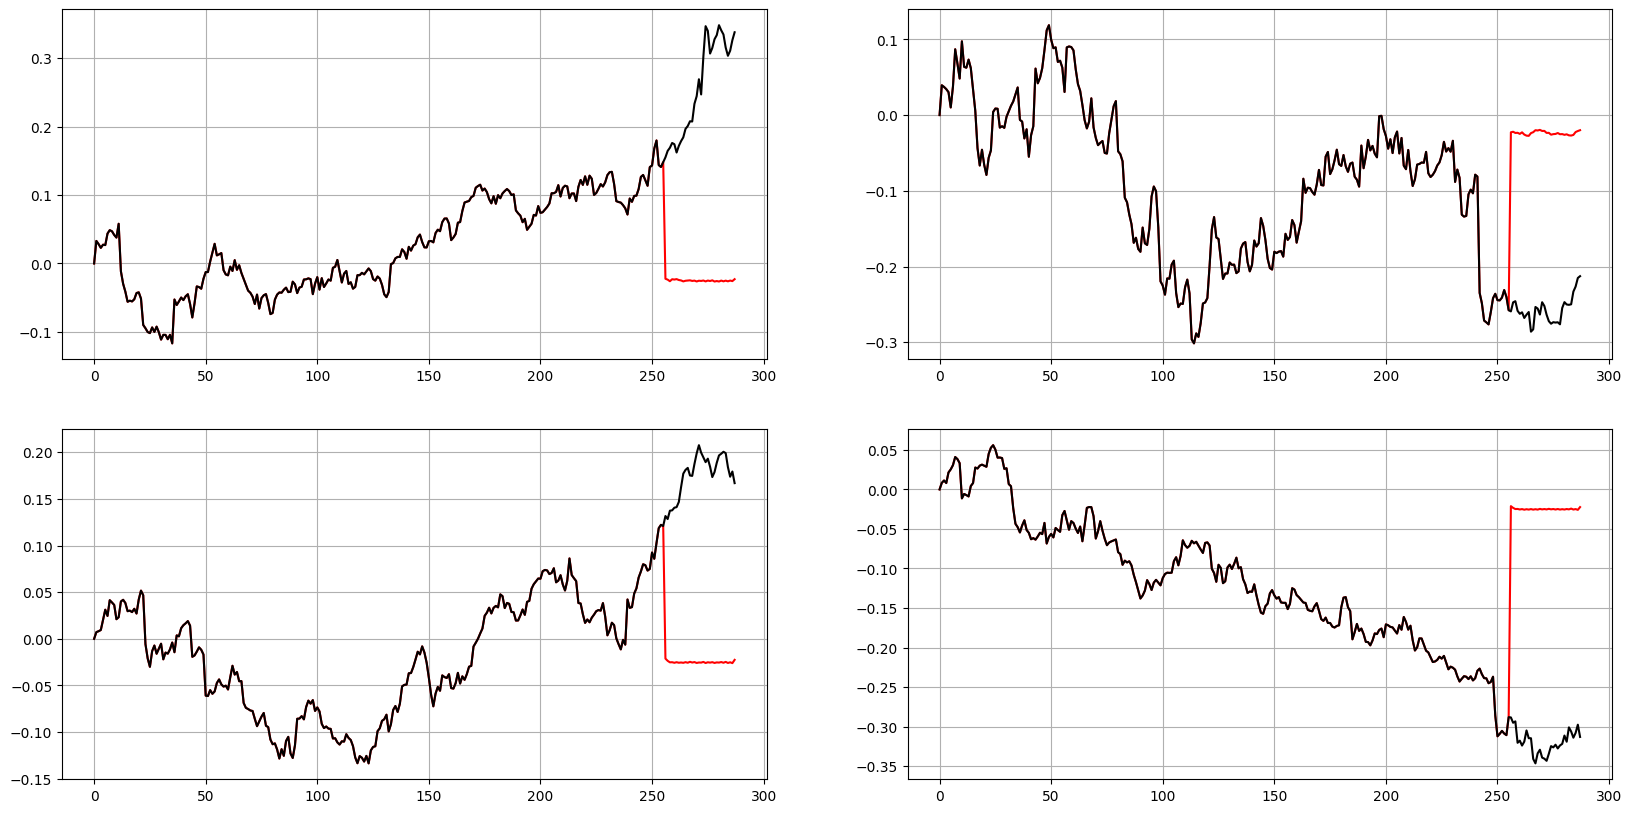

In [90]:
show_quality(myModel, val_loader)

# Обучаем модель